In [1]:
#Import the necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy import stats

In [2]:
#Read the data

data=pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
data.head()

year                                         track_name  track_popularity  \
0  2000                                             7 Days                73   
1  2000           Absolutely (Story of a Girl) - Radio Mix                69   
2  2000  Against All Odds (Take A Look at Me Now) - Mar...                61   
3  2000                               All The Small Things                84   
4  2000                                             Amazed                72   

                                         album   artist_name  \
0                                Born to Do It   Craig David   
1                            The Madding Crowd     Nine Days   
2  Against All Odds (Take A Look at Me Now) EP  Mariah Carey   
3                           Enema Of The State     blink-182   
4                                 Lonely Grill      Lonestar   

                                       artist_genres  artist_popularity  \
0                                   ['british soul']                 62   
1                                       ['pop rock']                 49   
2         ['dance pop'; 'pop'; 'urban contemporary']                 76   
3  ['alternative metal'; 'modern rock'; 'pop punk...                 75   
4  ['contemporary country'; 'country'; 'country r...                 57   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.659   0.812  4.0      87.0   0.0       0.0487      0.230000   
1         0.481   0.940  7.0      71.0   1.0       0.0660      0.000891   
2         0.542   0.498  1.0      80.0   1.0       0.0299      0.490000   
3         0.434   0.897  0.0      69.0   1.0       0.0488      0.010300   
4         0.561   0.543  1.0      92.0   1.0       0.0324      0.260000   

   instrumentalness  liveness  valence    tempo  duration_ms  
0               0.0    0.0951    0.888   83.014     235133.0  
1               0.0    0.0939    0.660   96.493     189333.0  
2               0.0    0.1010    0.218  117.763     201933.0  
3               0.0    0.6120    0.684  148.726     167067.0  
4               0.0    0.1240    0.243  139.803     240867.0

In [3]:
data.shape

(2300, 19)

In [4]:
#Percentage of missing values in each row
data.isna().mean()*100

year                 0.000000
track_name           0.000000
track_popularity     0.000000
album                0.000000
artist_name          0.000000
artist_genres        0.000000
artist_popularity    0.000000
danceability         0.043478
energy               0.043478
key                  0.043478
loudness             0.043478
mode                 0.043478
speechiness          0.043478
acousticness         0.043478
instrumentalness     0.043478
liveness             0.043478
valence              0.043478
tempo                0.043478
duration_ms          0.043478
dtype: float64

Seems like there's the same number of missing values. Being less than 0.5%, we can just drop them

In [5]:
data.dropna(inplace=True)

In [6]:
#Function to include median, mode, kurtosis, skewness and type of variable

def describex(data):
    data = pd.DataFrame(data)
    stats = pd.DataFrame(data.describe(include='all'))

    median = data.select_dtypes(include=[np.number]).median()
    md=pd.DataFrame(index=data.columns)
    md['median'] = median.reindex(data.columns).fillna('N/A')

    mode=pd.DataFrame(data.select_dtypes(include=[np.number]).mode().loc[0])
    mo=pd.DataFrame(index=data.columns)
    mo['mode']= mode.reindex(data.columns).fillna('N/A')

    inter=pd.DataFrame(data.select_dtypes(include=[np.number]).quantile(0.75)-data.select_dtypes(include=[np.number]).quantile(0.25))
    iqr=pd.DataFrame(index=data.columns)
    iqr['IQR'] = inter.reindex(data.columns).fillna('N/A')

    rang=pd.DataFrame(data.select_dtypes(include=[np.number]).max()-data.select_dtypes(include=[np.number]).min())
    ran=pd.DataFrame(index=data.columns)
    ran['range'] = rang.reindex(data.columns).fillna('N/A')    

    skewness = data.select_dtypes(include=[np.number]).skew()
    rs = pd.DataFrame(index=data.columns)
    rs['skewness'] = skewness.reindex(data.columns).fillna('N/A')

    kurtosis = data.select_dtypes(include=[np.number]).kurtosis()
    rk = pd.DataFrame(index=data.columns)
    rk['kurtosis'] = kurtosis.reindex(data.columns).fillna('N/A')

    types=pd.DataFrame(data.dtypes, columns=['type']).map(lambda x: 'numerical' if x=='int64' or x=='float64' else 'categorical')
    types=types.T

    skewness_df = rs.T
    kurtosis_df = rk.T
    median_df = md.T
    mode_df = mo.T
    iqr_df = iqr.T
    rang_df = ran.T

    stats=pd.concat([stats.iloc[:5], median_df, mode_df, stats.iloc[5:]], ignore_index=False)
    stats=pd.concat([stats.iloc[:13], iqr_df, rang_df, stats.iloc[13:]], ignore_index=False)
    stats=pd.concat([stats, kurtosis_df, skewness_df, types], ignore_index=False)
    
    return stats

In [7]:
describex(data)

year   track_name track_popularity        album  artist_name  \
count          2299.0         2299           2299.0         2299         2299   
unique            NaN         2120              NaN         1663          891   
top               NaN         Home              NaN    18 Months        Drake   
freq              NaN            5              NaN            8           32   
mean      2011.003045          NaN        70.944759          NaN          NaN   
median         2011.0          N/A             72.0          N/A          N/A   
mode           2000.0          N/A             73.0          N/A          N/A   
std          6.634528          NaN        12.294047          NaN          NaN   
min            2000.0          NaN              0.0          NaN          NaN   
25%            2005.0          NaN             66.0          NaN          NaN   
50%            2011.0          NaN             72.0          NaN          NaN   
75%            2017.0          NaN             79.0          NaN          NaN   
max            2022.0          NaN            100.0          NaN          NaN   
IQR              12.0          N/A             13.0          N/A          N/A   
range            22.0          N/A            100.0          N/A          N/A   
kurtosis    -1.204134          N/A        10.358751          N/A          N/A   
skewness    -0.000866          N/A        -2.341099          N/A          N/A   
type        numerical  categorical        numerical  categorical  categorical   

         artist_genres artist_popularity danceability     energy        key  \
count             2299            2299.0       2299.0     2299.0     2299.0   
unique             698               NaN          NaN        NaN        NaN   
top            ['pop']               NaN          NaN        NaN        NaN   
freq               135               NaN          NaN        NaN        NaN   
mean               NaN         72.873423     0.660116   0.693047   5.277947   
median             N/A              74.0        0.671      0.712        5.0   
mode               N/A              87.0        0.687      0.862        1.0   
std                NaN         12.180506     0.141137   0.164838   3.628494   
min                NaN              29.0        0.162     0.0519        0.0   
25%                NaN              65.0        0.572      0.586        2.0   
50%                NaN              74.0        0.671      0.712        5.0   
75%                NaN              82.0       0.7595       0.82        8.0   
max                NaN             100.0        0.975      0.999       11.0   
IQR                N/A              17.0       0.1875      0.234        6.0   
range              N/A              71.0        0.813     0.9471       11.0   
kurtosis           N/A         -0.059094    -0.015515   0.170401   -1.30484   
skewness           N/A         -0.409799    -0.398012  -0.630005   0.023334   
type       categorical         numerical    numerical  numerical  numerical   

           loudness       mode speechiness acousticness instrumentalness  \
count        2299.0     2299.0      2299.0       2299.0           2299.0   
unique          NaN        NaN         NaN          NaN              NaN   
top             NaN        NaN         NaN          NaN              NaN   
freq            NaN        NaN         NaN          NaN              NaN   
mean       73.00696   0.598521    0.097795     0.157689         0.013766   
median         74.0        1.0      0.0568       0.0689              0.0   
mode           70.0        1.0      0.0338        0.107              0.0   
std       15.643937   0.490304    0.092445     0.203844          0.08399   
min           -56.0        0.0      0.0225     0.000013              0.0   
25%            63.0        0.0       0.038       0.0165              0.0   
50%            74.0        1.0      0.0568       0.0689              0.0   
75%            83.0        1.0      0.1155        0.223        

There seems to be something weird with instrumentalness. Upon manual inspection and statistics review, it looks like the dataset contains mainly values very close to zero and only a handful of values above 0.1. Given this, we will remove it from the dataset

In [8]:
data=data.drop('instrumentalness', axis=1)

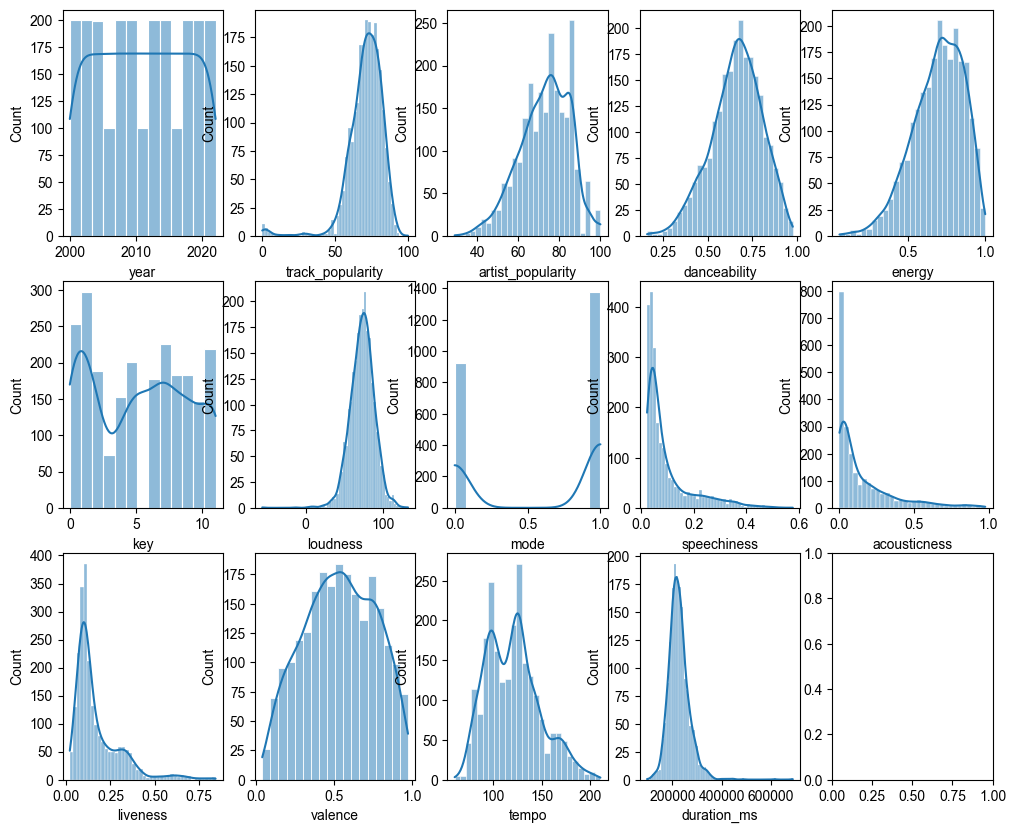

In [9]:
#Visualizar las variables continuas
def plot_ghraphs(data:pd.DataFrame, rows:int, cols:int):
    # df=data[data]
    fig, axes = plt.subplots(rows,cols, figsize=(12,10))
    axes = axes.flatten()

    sns.set_theme(font_scale=0.7)

    i=0
    for col in data.columns:
        if data[col].dtype=='int64' or data[col].dtype=='float64':
            sns.histplot(data[col], ax=axes[i], kde=True)
            i+=1
        # elif data[col].dtype=='object':
        #     axes[i].pie(data[col].value_counts(),labels=data[col].astype(str).unique(), autopct=lambda p: f'{int(p * sum(data[col].value_counts()) / 100)}')

    plt.show()

plot_ghraphs(data, 3,5)

Now we have to deal with the categorical values. There are three options: creating dummy variables (which seems counterproductive given that there are too many different values for album, artist, genres, etc.), encode each categorical variable, or dropping them from the analysis.

In [10]:
categorical=[i for i in data.dtypes[data.dtypes=='object'].index]
categorical


['track_name', 'album', 'artist_name', 'artist_genres']

In [11]:
data2=data.drop(categorical, axis=1)
describex(data2)

year track_popularity artist_popularity danceability  \
count          2299.0           2299.0            2299.0       2299.0   
mean      2011.003045        70.944759         72.873423     0.660116   
std          6.634528        12.294047         12.180506     0.141137   
min            2000.0              0.0              29.0        0.162   
25%            2005.0             66.0              65.0        0.572   
median         2011.0             72.0              74.0        0.671   
mode           2000.0             73.0              87.0        0.687   
50%            2011.0             72.0              74.0        0.671   
75%            2017.0             79.0              82.0       0.7595   
max            2022.0            100.0             100.0        0.975   
IQR              12.0             13.0              17.0       0.1875   
range            22.0            100.0              71.0        0.813   
kurtosis    -1.204134        10.358751         -0.059094    -0.015515   
skewness    -0.000866        -2.341099         -0.409799    -0.398012   
type        numerical        numerical         numerical    numerical   

             energy        key   loudness       mode speechiness acousticness  \
count        2299.0     2299.0     2299.0     2299.0      2299.0       2299.0   
mean       0.693047   5.277947   73.00696   0.598521    0.097795     0.157689   
std        0.164838   3.628494  15.643937   0.490304    0.092445     0.203844   
min          0.0519        0.0      -56.0        0.0      0.0225     0.000013   
25%           0.586        2.0       63.0        0.0       0.038       0.0165   
median        0.712        5.0       74.0        1.0      0.0568       0.0689   
mode          0.862        1.0       70.0        1.0      0.0338        0.107   
50%           0.712        5.0       74.0        1.0      0.0568       0.0689   
75%            0.82        8.0       83.0        1.0      0.1155        0.223   
max           0.999       11.0      132.0        1.0       0.576        0.978   
IQR           0.234        6.0       20.0        1.0      0.0775       0.2065   
range        0.9471       11.0      188.0        1.0      0.5535     0.977987   
kurtosis   0.170401   -1.30484   2.952067  -1.839814    3.334065     2.986438   
skewness  -0.630005   0.023334  -0.503522  -0.402227    1.920069     1.823303   
type      numerical  numerical  numerical  numerical   numerical    numerical   

           liveness    valence      tempo    duration_ms  
count        2299.0     2299.0     2299.0         2299.0  
mean       0.172618    0.53511  120.51245  226033.494128  
std         0.13162   0.227821  27.617729   42063.678588  
min           0.021     0.0377     60.019        97393.0  
25%         0.08995     0.3605    98.5695       200179.5  
median        0.119       0.54      120.0       221653.0  
mode          0.107        0.4     79.983       236133.0  
50%           0.119       0.54      120.0       221653.0  
75%            0.22      0.722    137.028       245950.0  
max           0.843      0.974    210.857       688453.0  
IQR         0.13005     0.3615    38.4585        45770.5  
range         0.822     0.9363    150.838       591060.0  
kurtosis   4.711624  -0.904908  -0.095389      11.044043  
skewness   1.997885  -0.076419   0.553702       1.626116  
type      numerical  numerical  numerical      numerical

Now to do some outlier cleaning

In [12]:
#Clean Track Popularity
q1 = data['track_popularity'].quantile(0.25)
q3 = data['track_popularity'].quantile(0.75)
tp_median=data['track_popularity'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['track_popularity']>lower_bound)&(data2['track_popularity']<upper_bound)]
data2.shape

(2203, 14)

In [13]:
#Clean Loudness - It has two negative values which make no sense
q1 = data['loudness'].quantile(0.25)
q3 = data['loudness'].quantile(0.75)
tp_median=data['loudness'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['loudness']>lower_bound)&(data2['loudness']<upper_bound)]
data2.shape

(2087, 14)

In [14]:
#Clean Duration - It has a little number of right tail outliers
q1 = data['duration_ms'].quantile(0.25)
q3 = data['duration_ms'].quantile(0.75)
tp_median=data['duration_ms'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['duration_ms']>lower_bound)&(data2['duration_ms']<upper_bound)]
data2.shape

(1913, 14)

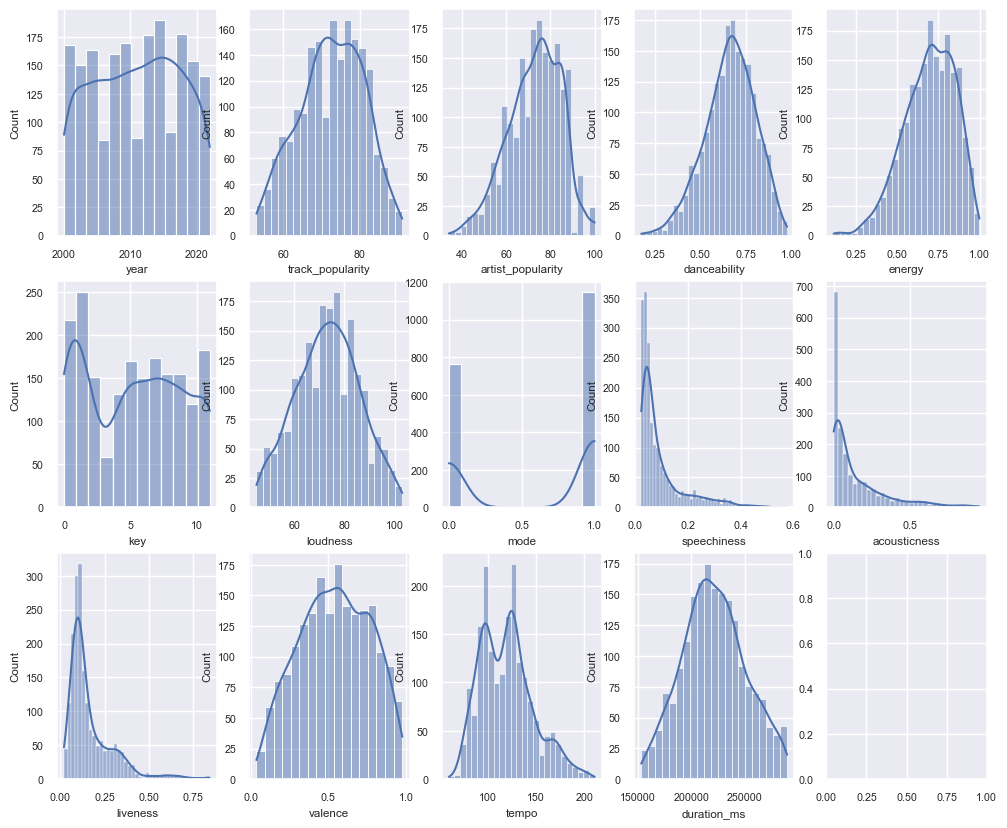

In [15]:
plot_ghraphs(data2,3,5)

Now let's apply some transformations

In [16]:
data3=data2.copy()

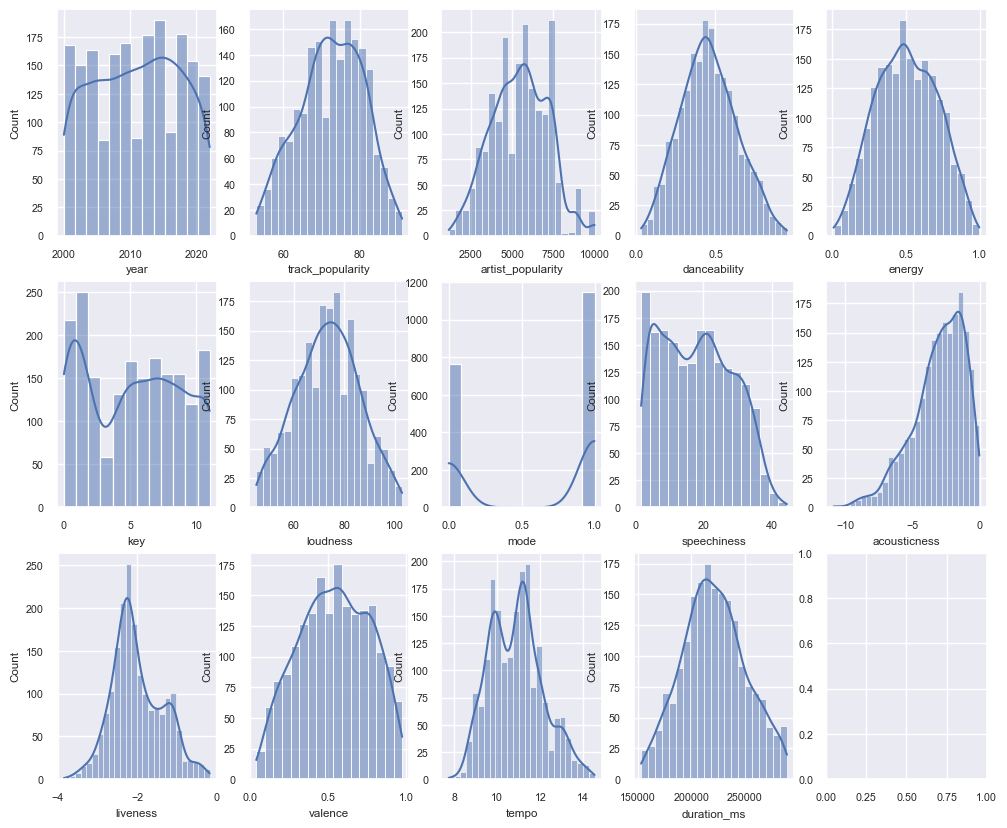

In [17]:
data3['artist_popularity']=data3['artist_popularity']**2
data3['danceability']=data3['danceability']**2
data3['energy']=data3['energy']**2
data3['speechiness']=1/data3['speechiness']
data3['acousticness']=np.log(data3['acousticness'])
data3['liveness']=np.log(data3['liveness'])
data3['tempo']=np.sqrt(data3['tempo'])

plot_ghraphs(data3,3,5)

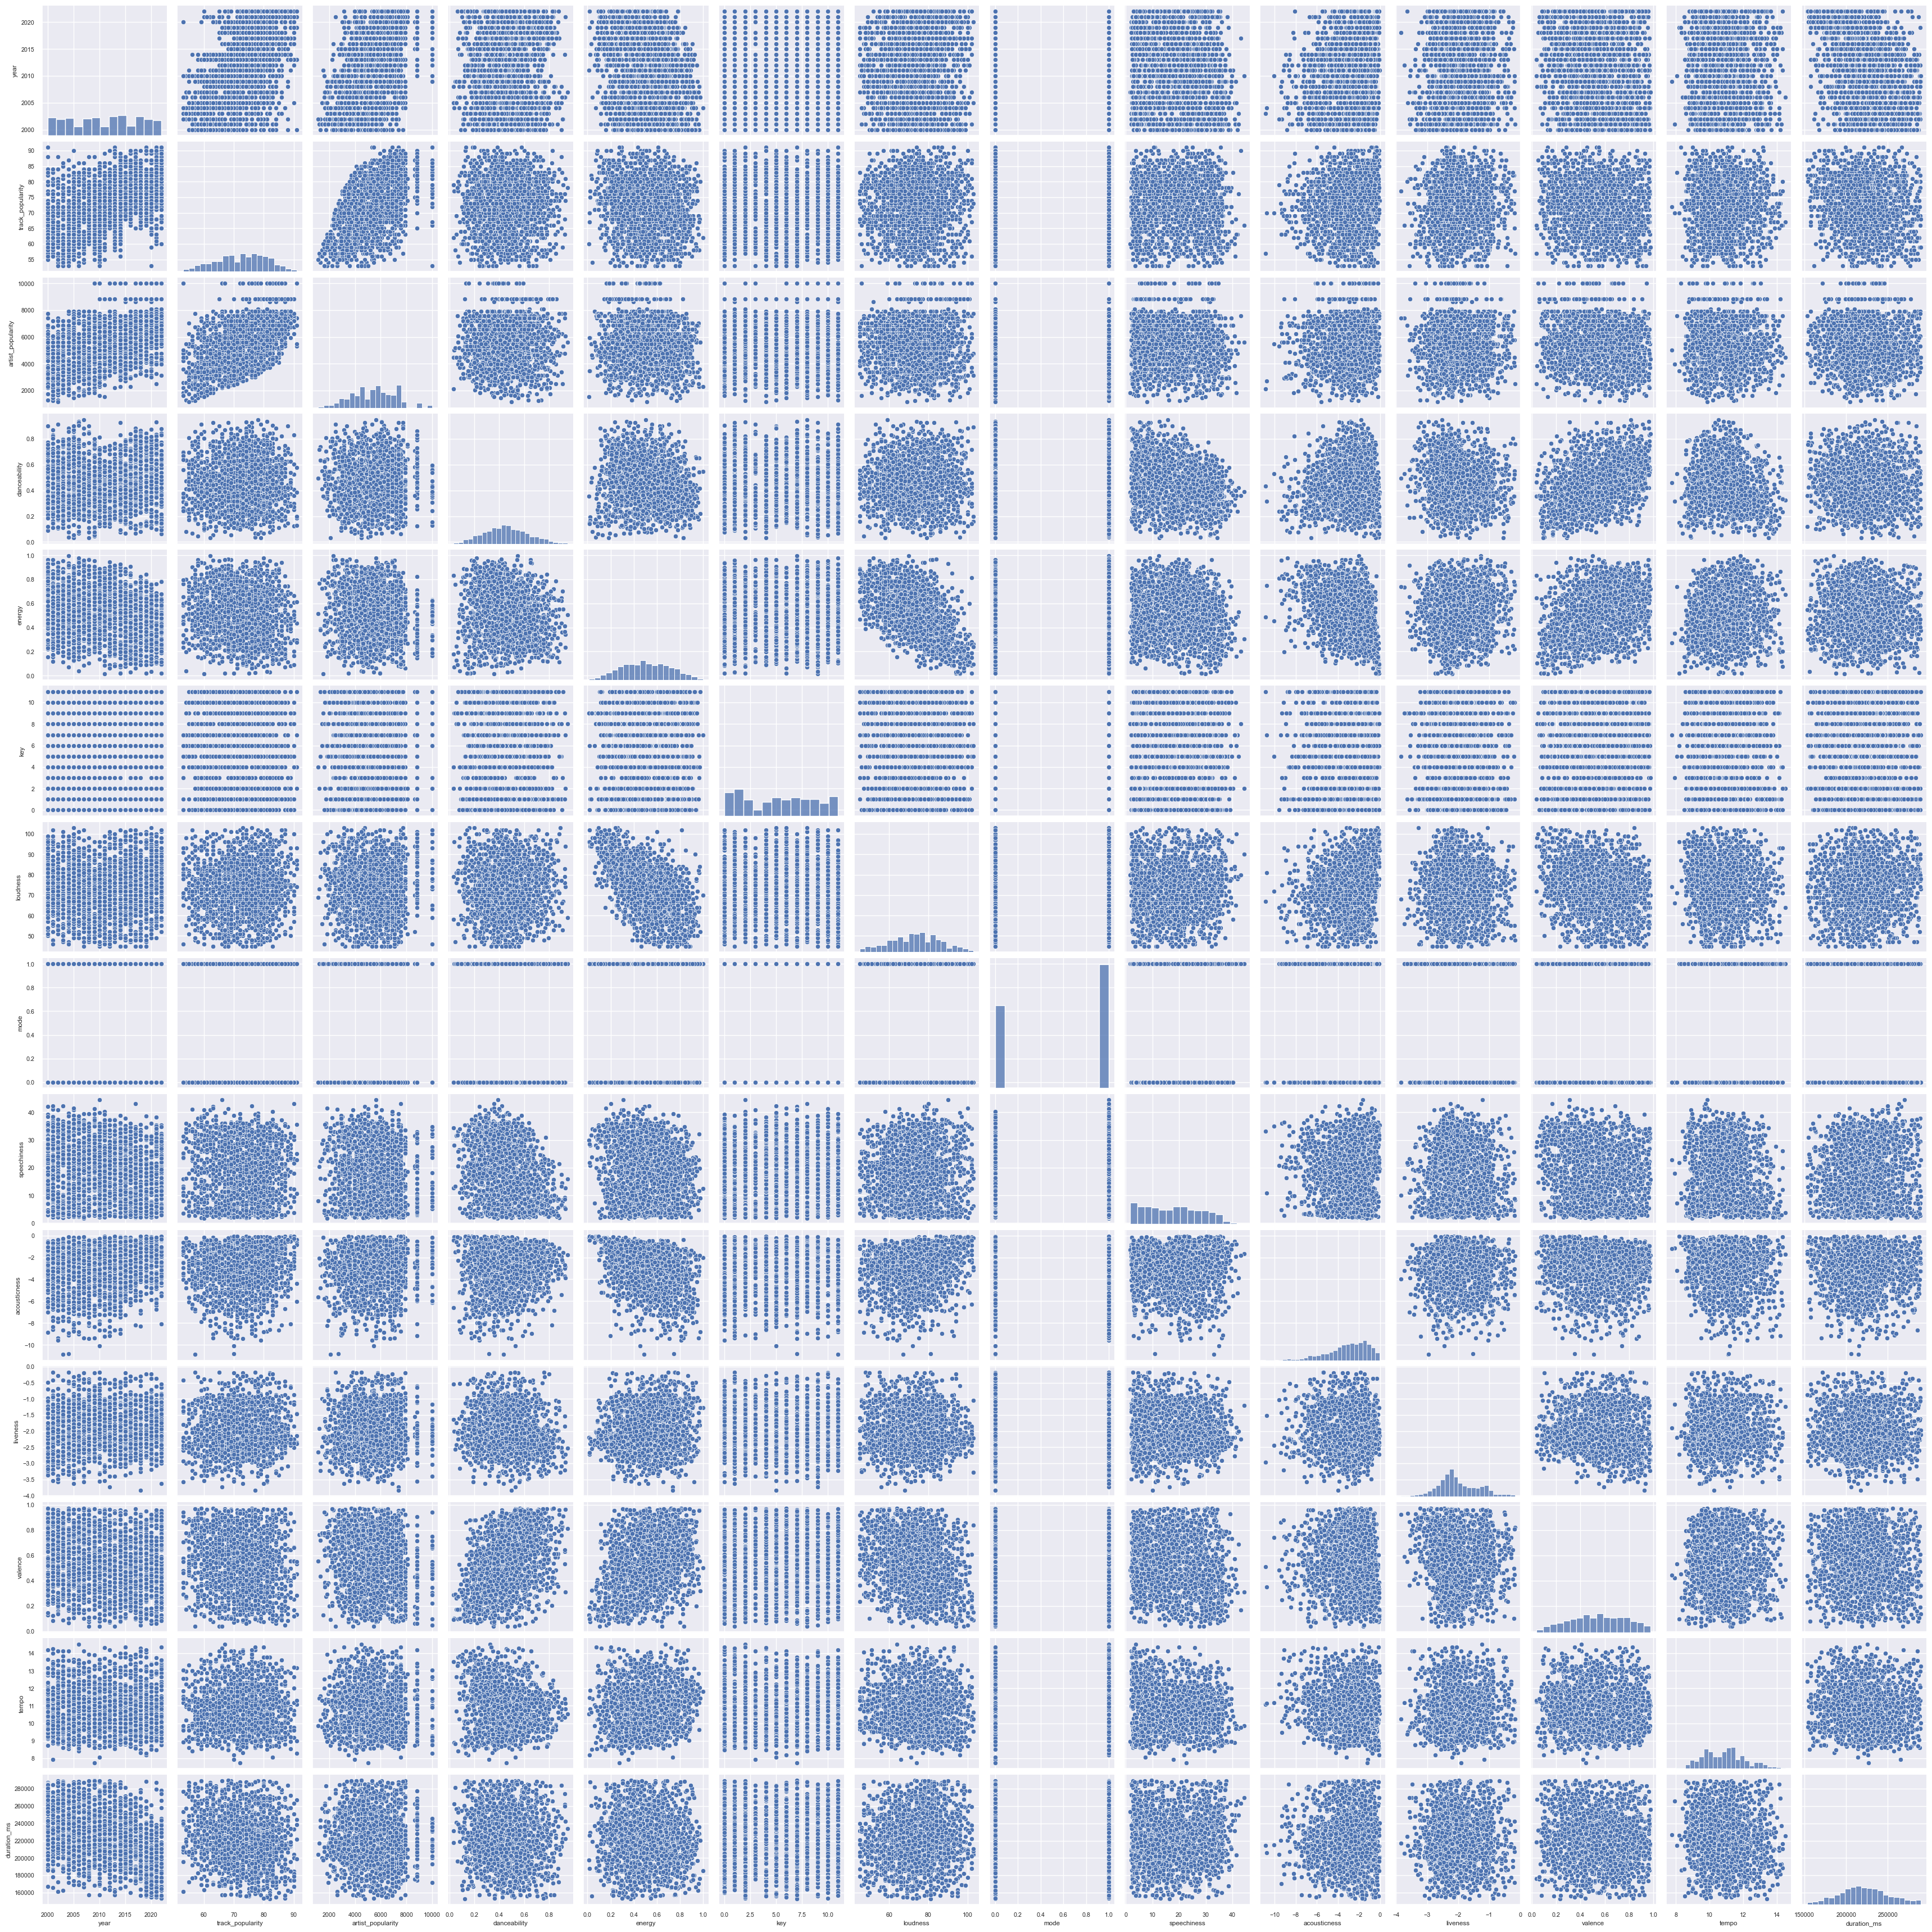

In [18]:
sns.pairplot(data3)

In [19]:
y=data3['track_popularity'].reset_index(drop=True)
X=data3.drop(['track_popularity'], axis=1).reset_index(drop=True)

<Axes: >

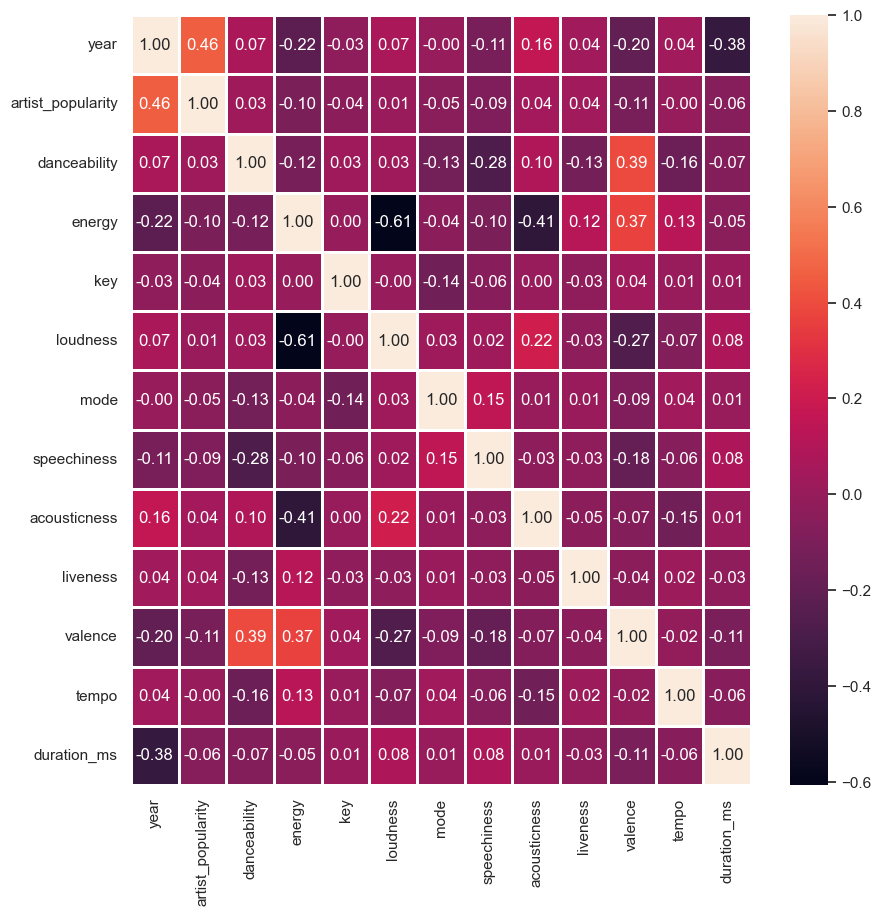

In [20]:
sns.set_theme(font_scale=1)
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(X.corr(),annot=True, fmt=".2f", linewidths=1, ax=ax)

Seems that Loudness and Energy have a high negative correlation (weird but ok). In that case, let's drop Energy which also has a relatively high negative correlation with acousticness

In [21]:
X=X.drop('energy', axis=1)

In [22]:
#Now let's create the scaler in order to standardize units

scaler=StandardScaler()

scaler.fit(X)

X_scaled=scaler.transform(X)

X_scaled

array([[-1.69821592, -0.94906809, -0.13290494, ...,  1.54581251,
        -1.4371014 ,  0.46025932],
       [-1.69821592, -1.79964414, -1.2793553 , ...,  0.53671821,
        -0.86039775, -1.07873409],
       [-1.69821592,  0.18974891, -0.926793  , ..., -1.41950845,
        -0.02697189, -0.65534289],
       ...,
       [ 1.69740909,  0.652467  , -0.53218515, ...,  0.16937248,
         1.00882771, -1.65219395],
       [ 1.69740909,  1.14465758,  1.24956437, ...,  1.51483154,
        -0.39934508, -1.64009706],
       [ 1.69740909,  1.24663239, -0.82104634, ...,  0.63851281,
         1.80721141, -0.93555394]])

# **K-Means**

In [23]:
#Create the function to calculate silhouette score and plot elbow graph
def silhouette_elbow(data:pd.DataFrame, min_k:int, max_k:int):

    k=list(range(min_k, max_k))
    inertia=[]
    score=[]

    for i in k:
        kmeans=KMeans(n_clusters=i)

        kmeans.fit(data)
        labels = kmeans.predict(data)
        centroids = kmeans.cluster_centers_

        inertia.append(kmeans.inertia_)
        score.append("{:.3f}".format(silhouette_score(data, labels=labels)))

        print(f'Silhouette score for {i} clusters:',silhouette_score(data, labels=labels))

    plt.figure(figsize=(8, 6))
    plt.plot(k, inertia, marker='o')

    for i, txt in enumerate(score):
        plt.text(k[i]+0.05, inertia[i], f"{txt}", fontsize=10, ha='left', va='bottom')

    plt.title("Elbow method to select k")
    plt.xlabel("Number of clusters (k) with silhouette value in each")
    plt.ylabel("Inertia")
    plt.ylim(min(inertia) - 10, max(inertia) + 100)
    plt.xticks(k)
    plt.grid(True)
    plt.show()

Silhouette score for 2 clusters: 0.09334826401277924
Silhouette score for 3 clusters: 0.09361031965875077
Silhouette score for 4 clusters: 0.09770622499793477
Silhouette score for 5 clusters: 0.08801072245526374
Silhouette score for 6 clusters: 0.08564292432712578
Silhouette score for 7 clusters: 0.0869791456831732
Silhouette score for 8 clusters: 0.08417581350695943


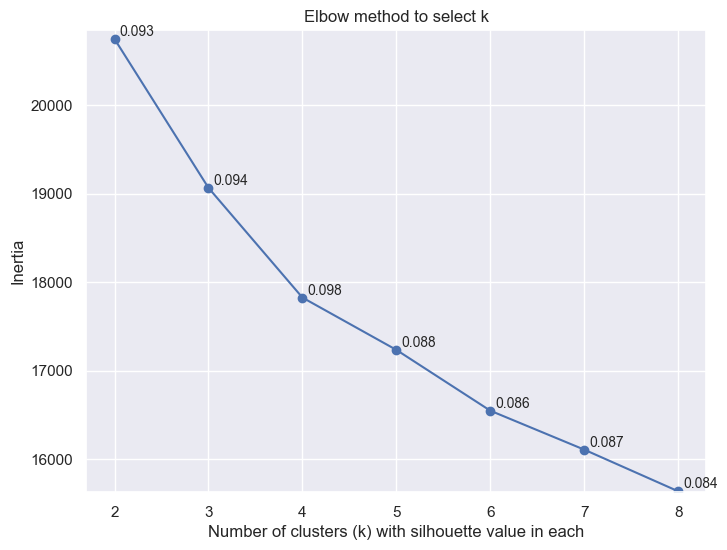

In [24]:
silhouette_elbow(X_scaled,2,9)

According to the analysis it seems that k=4 is the best option (although the values are quite bad)

In [25]:
#Run K-Means with the selected number of clusters

kmeans=KMeans(n_clusters=4, random_state=50)
kmeans.fit(X_scaled)

labels=kmeans.predict(X_scaled)
labels

array([0, 2, 1, ..., 3, 3, 3])

In [26]:
X.columns

Index(['year', 'artist_popularity', 'danceability', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [27]:
# Include the clusters in the data

X_clusters=pd.DataFrame(data=X_scaled, columns=X.columns)
X_clusters['Cluster']=labels

X_clusters

year  artist_popularity  danceability       key  loudness      mode  \
0    -1.698216          -0.949068     -0.132905 -0.345819  1.080968 -1.225012   
1    -1.698216          -1.799644     -1.279355  0.478716 -0.184765  0.816319   
2    -1.698216           0.189749     -0.926793 -1.170353  0.527210  0.816319   
3    -1.698216           0.100742     -1.522323 -1.445198 -0.342982  0.816319   
4    -1.698216          -1.299791     -0.808391 -1.170353  1.476509  0.816319   
...        ...                ...           ...       ...       ...       ...   
1908  1.697409           1.349786     -1.375356 -1.170353 -0.659415  0.816319   
1909  1.697409          -1.366399     -0.705520 -1.445198  1.555618 -1.225012   
1910  1.697409           0.652467     -0.532185 -0.070974  0.210776  0.816319   
1911  1.697409           1.144658      1.249564 -0.070974 -0.896740 -1.225012   
1912  1.697409           1.246632     -0.821046 -1.170353 -0.659415  0.816319   

      speechiness  acousticness  liveness   valence     tempo  duration_ms  \
0        0.238591      0.819896 -0.556434  1.545813 -1.437101     0.460259   
1       -0.285558     -2.066893 -0.576065  0.536718 -0.860398    -1.078734   
2        1.495894      1.213046 -0.463386 -1.419508 -0.026972    -0.655343   
3        0.234494     -0.794617  2.321672  0.642939  1.061379    -1.826927   
4        1.244586      0.883626 -0.146234 -1.308862  0.760427     0.652936   
...           ...           ...       ...       ...       ...          ...   
1908    -1.474635      0.981721 -1.061372 -0.883980 -1.420449    -1.059917   
1909    -0.593396      1.048436 -0.317441  1.289113  2.805222    -0.178625   
1910     0.856761     -0.337855  2.246628  0.169372  1.008828    -1.652194   
1911    -0.620741      0.325192 -0.236060  1.514832 -0.399345    -1.640097   
1912    -1.245802     -0.049359  1.380871  0.638513  1.807211    -0.935554   

      Cluster  
0           0  
1           2  
2           1  
3           2  
4           1  
...       ...  
1908        3  
1909        3  
1910        3  
1911        3  
1912        3  

[1913 rows x 13 columns]

In [28]:
# Visualize the clusters metrics

by_cluster=X_clusters.groupby('Cluster', as_index=True).mean()
by_cluster

year  artist_popularity  danceability       key  loudness  \
Cluster                                                                  
0       -0.865809          -0.573232      0.716417  0.152061 -0.042188   
1       -0.142331          -0.149057     -0.660876 -0.070342  0.520663   
2       -0.348816          -0.185109     -0.583871 -0.081521 -0.656558   
3        0.988444           0.660332      0.390824  0.000944  0.137865   

             mode  speechiness  acousticness  liveness   valence     tempo  \
Cluster                                                                      
0       -0.328703    -0.426301      0.225830 -0.359680  0.762060 -0.336426   
1        0.384589     0.912483      0.476264 -0.088899 -0.913065 -0.137976   
2        0.111299     0.047533     -1.044689  0.476769  0.165777  0.498851   
3       -0.122693    -0.387577      0.262311 -0.026795 -0.012920 -0.024377   

         duration_ms  
Cluster               
0           0.472076  
1           0.538877  
2          -0.133164  
3          -0.634622

<Axes: xlabel='Cluster'>

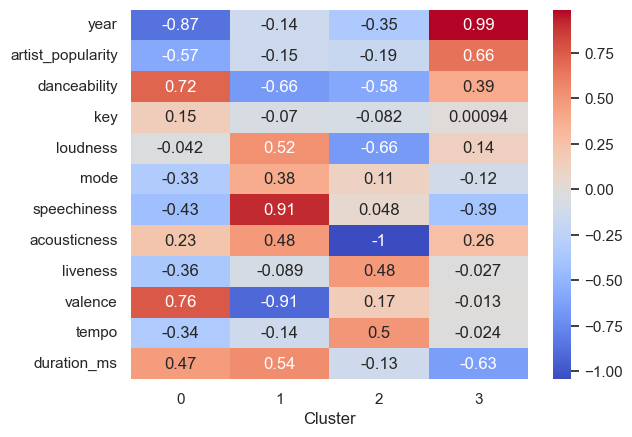

In [29]:
sns.heatmap(by_cluster.T,cmap="coolwarm", annot=True, cbar=True)

In [30]:
merged_ds=X_clusters.copy()
merged_ds['track_popularity']=y

merged_ds.groupby('Cluster',as_index=True)['track_popularity'].mean().T
#sns.heatmap(merged_ds.groupby('Cluster',as_index=True)['track_popularity'].mean().T,cmap="coolwarm", annot=True, cbar=True)

Cluster
0    68.160920
1    72.193103
2    71.451467
3    76.543333
Name: track_popularity, dtype: float64

It looks like the clustering doesn't affect the popularity of the tracks that much. (I already tried removing 'year' from X and running k=5, getting the same result in popularity). Given this, let's run a Linear Regression on the whole dataset.

# **Regression**

In [31]:
y

0       73
1       69
2       61
3       84
4       72
        ..
1908    86
1909    77
1910    78
1911    87
1912    76
Name: track_popularity, Length: 1913, dtype: int64

In [32]:
data_lr=pd.concat([y,X], axis=1)
data_lr

track_popularity  year  artist_popularity  danceability  key  loudness  \
0                   73  2000               3844      0.434281  4.0      87.0   
1                   69  2000               2401      0.231361  7.0      71.0   
2                   61  2000               5776      0.293764  1.0      80.0   
3                   84  2000               5625      0.188356  0.0      69.0   
4                   72  2000               3249      0.314721  1.0      92.0   
...                ...   ...                ...           ...  ...       ...   
1908                86  2022               7744      0.214369  1.0      65.0   
1909                77  2022               3136      0.332929  0.0      93.0   
1910                78  2022               6561      0.363609  5.0      76.0   
1911                87  2022               7396      0.678976  5.0      62.0   
1912                76  2022               7569      0.312481  1.0      65.0   

      mode  speechiness  acousticness  liveness  valence      tempo  \
0      0.0    20.533881     -1.469676 -2.352826    0.888   9.111202   
1      1.0    15.151515     -7.023166 -2.365525    0.660   9.823085   
2      1.0    33.444816     -0.713350 -2.292635    0.218  10.851866   
3      1.0    20.491803     -4.575611 -0.491023    0.684  12.195327   
4      1.0    30.864198     -1.347074 -2.087474    0.243  11.823832   
...    ...          ...           ...       ...      ...        ...   
1908   1.0     2.941176     -1.158362 -2.679463    0.339   9.131758   
1909   0.0    11.990408     -1.030019 -2.198225    0.830  14.347927   
1910   1.0    26.881720     -3.696912 -0.539568    0.577  12.130458   
1911   0.0    11.709602     -2.421369 -2.145581    0.881  10.392209   
1912   1.0     5.291005     -3.141915 -1.099613    0.683  13.115983   

      duration_ms  
0        235133.0  
1        189333.0  
2        201933.0  
3        167067.0  
4        240867.0  
...           ...  
1908     189893.0  
1909     216120.0  
1910     172267.0  
1911     172627.0  
1912     193594.0  

[1913 rows x 13 columns]

In [33]:
data_model, data_reserved = train_test_split(data_lr, test_size=0.1, random_state=42)

X_reserved=data_reserved.drop('track_popularity', axis=1)
y_reserved=data_reserved['track_popularity']

X_lr=data_model.drop('track_popularity', axis=1)
y_lr=data_model['track_popularity']

X_train, X_test, y_train, y_test= train_test_split(X_lr, y_lr, test_size=0.3, random_state=95)

print ("Sample size dataset reserved for prediction: ", data_reserved.shape[0], "records")
print ("Sample size train dataset: ", X_train.shape)
print ("Sample size test dataset: ", X_test.shape)

Sample size dataset reserved for prediction:  192 records
Sample size train dataset:  (1204, 12)
Sample size test dataset:  (517, 12)


In [34]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [35]:
result = stepwise_selection(X_train, y_train)
print('resulting features:')
print(result)

Add  artist_popularity              with p-value 1.986e-82
Add  year                           with p-value 5.129e-27
Add  tempo                          with p-value 0.01664
resulting features:
['artist_popularity', 'year', 'tempo']


In [36]:
X_train_stepwise=X_train
for item in X_train.columns:
    if item not in result:
        X_train_stepwise=X_train_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

In [37]:
X_train_stepwise

year  artist_popularity      tempo
133   2001               2916  11.087425
17    2000               2500   9.250135
1365  2016               5929   9.848401
244   2002               4489   9.849112
1546  2018               6400  10.583430
...    ...                ...        ...
368   2004               6889  10.488947
720   2008               4225  10.953264
1241  2014               5929   9.063222
1593  2018               5329  10.297864
954   2011               7569  11.312471

[1204 rows x 3 columns]

In [52]:
#Define the linear regression

lm=LinearRegression()

model=lm.fit(X_train_stepwise,y_train)

model.score(X_train_stepwise, y_train)

0.33577009669742797

In [57]:
def adj_r2(X,y,r2):
    '''Returns the adjusted coefficient of determination of the prediction.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples. For some estimators this may be a precomputed
            kernel matrix or a list of generic objects instead with shape
            ``(n_samples, n_samples_fitted)``, where ``n_samples_fitted``
            is the number of samples used in the fitting for the estimator.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True values for `X`.

        r2 : R^2 score of the Linear Regression Model

        Returns
        -------
        score : float
            :math:`ADJ_R^2` of ``self.predict(X)`` w.r.t. `y`.'''
    
    n=X.shape[0]
    p=X.shape[1]

    return 1-(((1-r2)*(n-1))/(n-p-1))

        

In [58]:
adj_r2(X_train_stepwise,y_train,model.score(X_train_stepwise, y_train))

0.33410952193917154

In [53]:
# print coefficients (but not confidence intervals: sklearn does not store them)
coeff_df = pd.DataFrame(model.coef_,X_train_stepwise.columns,columns=['Coefficient'])
print("Intercept: ", model.intercept_)
coeff_df

Intercept:  -709.0665398863254


Coefficient
year                  0.385536
artist_popularity     0.001879
tempo                -0.383981

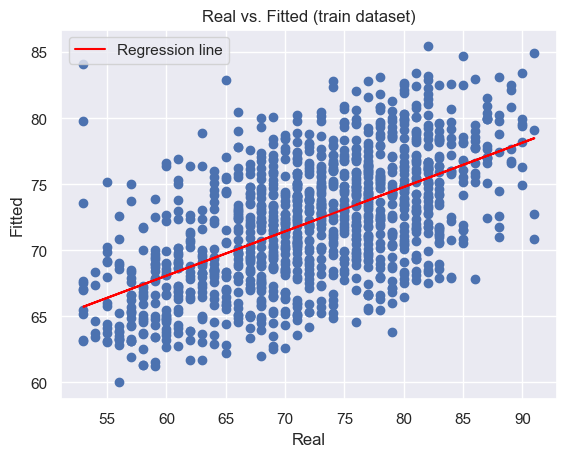

In [40]:
y_train_hat=model.predict(X_train_stepwise)

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,y_train_hat)

coef = np.polyfit(y_train, y_train_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

Adjusted R2 for the testing set: 0.27552771624491135


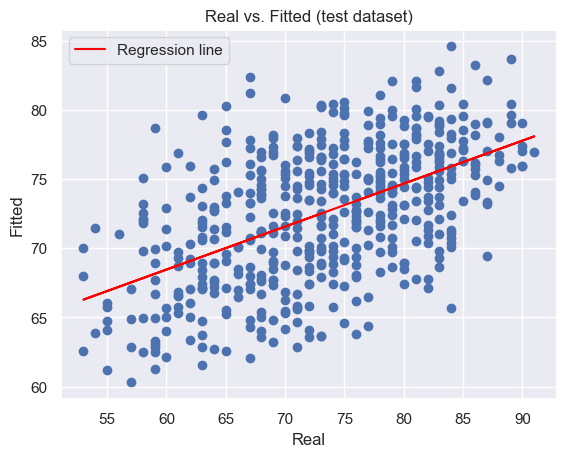

In [59]:
y_test_hat=model.predict(X_test[X_train_stepwise.columns])

print(f'Adjusted R2 for the testing set: {adj_r2(X_test[X_train_stepwise.columns],y_test,r2_score(y_test, y_test_hat))}')

plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,y_test_hat)

coef = np.polyfit(y_test, y_test_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()


In [60]:
lm2=LinearRegression()

model_2=lm2.fit(X_train,y_train)

model_2.score(X_train, y_train)

0.3401265661353431

In [63]:
adj_r2(X_train,y_train,model_2.score(X_train, y_train))

0.3334779673054725

In [43]:
# print coefficients (but not confidence intervals: sklearn does not store them)
coeff_df = pd.DataFrame(model_2.coef_,X_train.columns,columns=['Coefficient'])
print("Intercept: ", model_2.intercept_)
coeff_df

Intercept:  -657.109849010489


Coefficient
year                  0.359961
artist_popularity     0.001926
danceability          0.530755
key                   0.006844
loudness              0.007353
mode                  0.195938
speechiness           0.039914
acousticness          0.073794
liveness             -0.087310
valence               0.094751
tempo                -0.344066
duration_ms          -0.000013

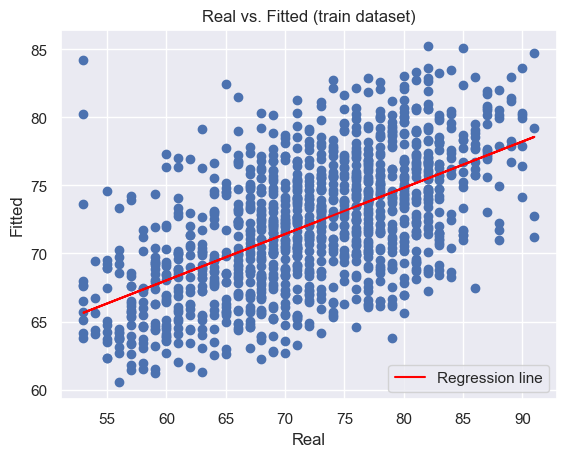

In [44]:
y_train_hat2=model_2.predict(X_train)

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,y_train_hat2)

coef = np.polyfit(y_train, y_train_hat2, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

R2 for the testing set: 0.2710020821128214


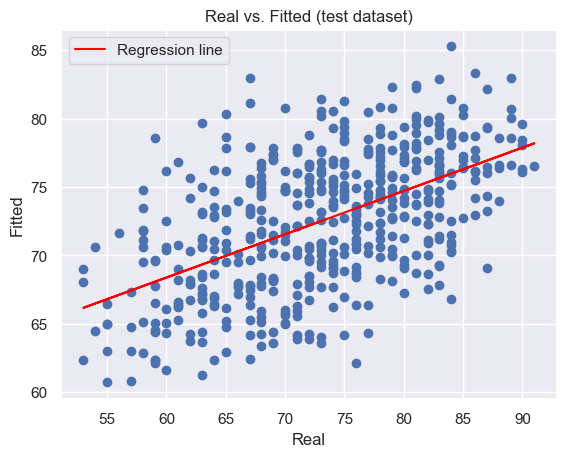

In [64]:
y_test_hat2=model_2.predict(X_test)

print(f'R2 for the testing set: {adj_r2(X_test,y_test,r2_score(y_test, y_test_hat2))}')

plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,y_test_hat2)

coef = np.polyfit(y_test, y_test_hat2, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()


# **Random Forest**

In [46]:
#Run Random Forest to try and improve the accuracy

from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor()
rf.fit(X_train_stepwise,y_train)

rf.score(X_train_stepwise, y_train)

0.902201941874569

RF R2 for the training set: 0.902201941874569


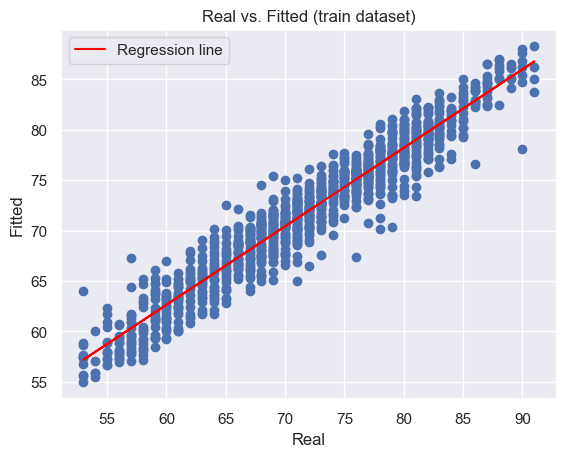

In [47]:
rf_y_hat=rf.predict(X_train_stepwise)

print(f'RF R2 for the training set: {r2_score(y_train, rf_y_hat)}')

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,rf_y_hat)

coef = np.polyfit(y_train,rf_y_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

RF R2 for the testing set: 0.23057860125880292


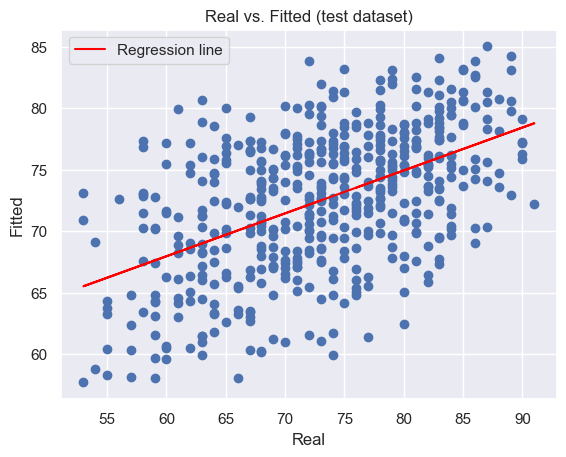

In [48]:
rf_y_test_hat=rf.predict(X_test[X_train_stepwise.columns])

print(f'RF R2 for the testing set: {r2_score(y_test, rf_y_test_hat)}')

plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,rf_y_test_hat)

coef = np.polyfit(y_test,rf_y_test_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

Even with Random Forest, the performance of the model is very poor in the testing set, plus we can see it is overfitted. According to all the analyses done, we can inferr that there must be missing variables in the set that can help us both segment and predict with higher performance.